In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import spinesTS
spinesTS.__version__

'0.3.14'

In [3]:
from spinesTS.preprocessing import split_series
from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score

In [4]:
from spinesTS.data import BuiltInSeriesData
from spinesTS.nn import *
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error

In [5]:
series_data = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [6]:
cs = series_data['Web_Sales']

x_train, x_test, y_train, y_test = split_series(cs['type_a'], cs['type_a'], 128, 30, train_size=0.9)

In [7]:
x_train.shape, x_test.shape

((1738, 128), (194, 128))

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler2 = MinMaxScaler()
y_train = scaler2.fit_transform(y_train)
y_test = scaler2.transform(y_test)

# SegRNN

Using cpu backend
Epoch 1/3000  
55/55 - p0 -  [*lr: 0.0009045] - loss: 0.0726 - mae: 0.1342 - val_loss: 0.1225 - val_mae: 0.1225 - 0.93s/epoch - 0.017s/step
Epoch 2/3000  
55/55 - p0 -  [*lr: 0.0006545] - loss: 0.0888 - mae: 0.1239 - val_loss: 0.0551 - val_mae: 0.0551 - 0.91s/epoch - 0.017s/step
Epoch 3/3000  
55/55 - p0 -  [*lr: 0.0003455] - loss: 0.0478 - mae: 0.1407 - val_loss: 0.0419 - val_mae: 0.0419 - 0.91s/epoch - 0.017s/step
Epoch 4/3000  
55/55 - p1 -  [*lr: 9.55e-05] - loss: 0.0442 - mae: 0.1326 - val_loss: 0.0623 - val_mae: 0.0623 - 0.90s/epoch - 0.016s/step
Epoch 5/3000  
55/55 - p2 - [*lr: 0.000000e+00] - loss: 0.2221 - mae: 0.1740 - val_loss: 0.2370 - val_mae: 0.2370 - 0.90s/epoch - 0.016s/step
Epoch 6/3000  
55/55 - p3 -  [*lr: 9.55e-05] - loss: 0.2154 - mae: 0.1190 - val_loss: 0.2370 - val_mae: 0.2370 - 0.90s/epoch - 0.016s/step
Epoch 7/3000  
55/55 - p4 -  [*lr: 0.0003455] - loss: 0.2044 - mae: 0.1271 - val_loss: 0.2179 - val_mae: 0.2179 - 0.91s/epoch - 0.017s/step
Ep

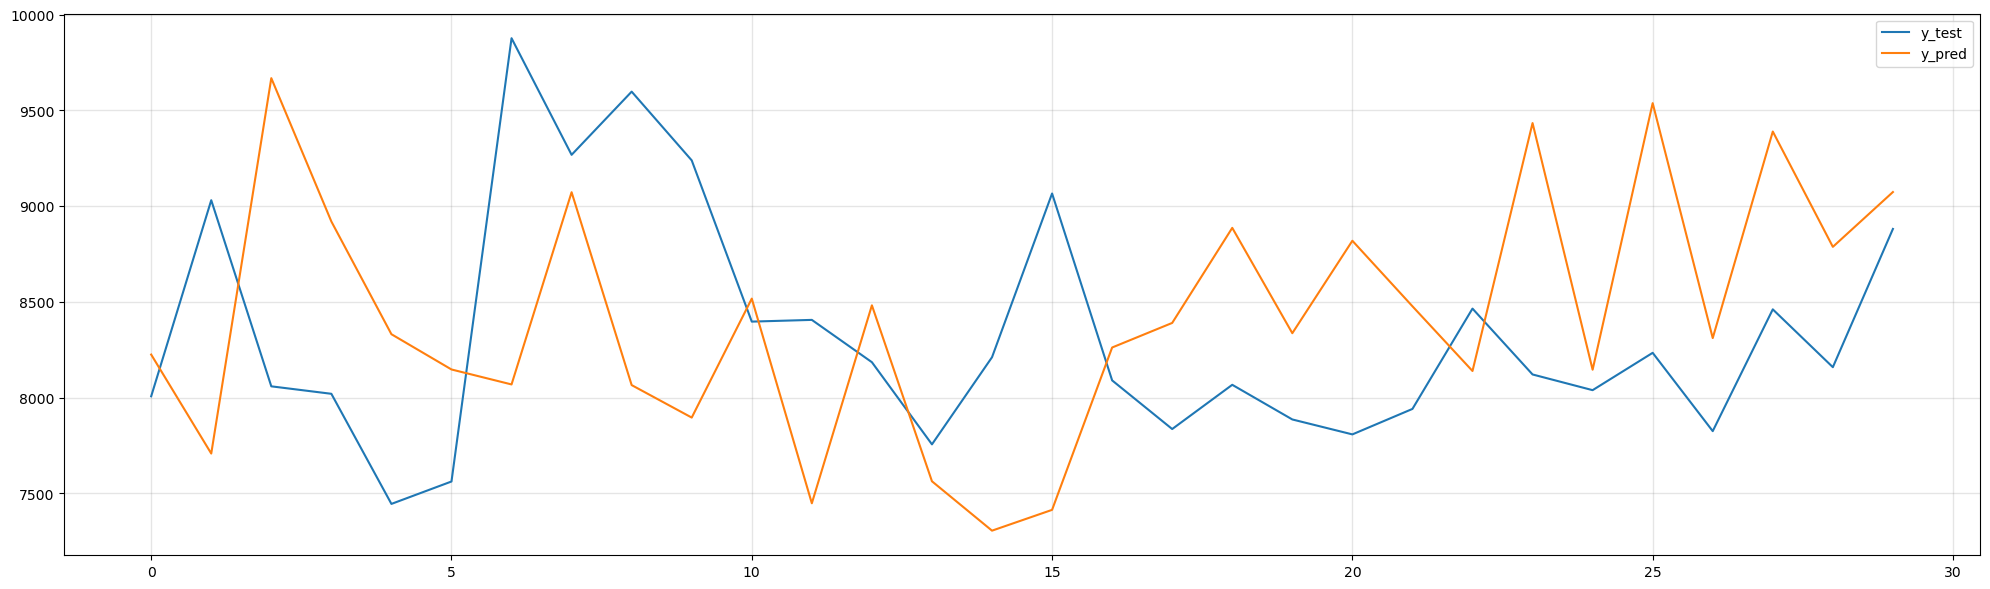

In [12]:
from spinesTS.nn._seg_rnn import SegRNN

model = SegRNN(128, 30, random_seed=42, loss_fn='mae', learning_rate=0.001, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32, min_delta=0, patience=100, epochs=3000, verbose=True)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))

y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# StackingRNN

Using cpu backend
Epoch 1/3000  
55/55 - p0 - loss: 0.0856 - mae: 0.1359 - val_loss: 0.1212 - val_mae: 0.1212 - 0.50s/epoch - 0.009s/step
Epoch 2/3000  
55/55 - p0 - loss: 0.1130 - mae: 0.1409 - val_loss: 0.1185 - val_mae: 0.1185 - 0.46s/epoch - 0.008s/step
Epoch 3/3000  
55/55 - p0 - loss: 0.0627 - mae: 0.1254 - val_loss: 0.0764 - val_mae: 0.0764 - 0.45s/epoch - 0.008s/step
Epoch 4/3000  
55/55 - p1 - loss: 0.1585 - mae: 0.1318 - val_loss: 0.1638 - val_mae: 0.1638 - 0.47s/epoch - 0.009s/step
Epoch 5/3000  
55/55 - p2 - loss: 0.0840 - mae: 0.1303 - val_loss: 0.1089 - val_mae: 0.1089 - 0.46s/epoch - 0.008s/step
Epoch 6/3000  
55/55 - p3 - loss: 0.0702 - mae: 0.1277 - val_loss: 0.0848 - val_mae: 0.0848 - 0.49s/epoch - 0.009s/step
Epoch 7/3000  
55/55 - p4 - loss: 0.1340 - mae: 0.1493 - val_loss: 0.1617 - val_mae: 0.1617 - 0.46s/epoch - 0.008s/step
Epoch 8/3000  
55/55 - p5 - loss: 0.0875 - mae: 0.1200 - val_loss: 0.0984 - val_mae: 0.0984 - 0.45s/epoch - 0.008s/step
Epoch 9/3000  
55/55 -

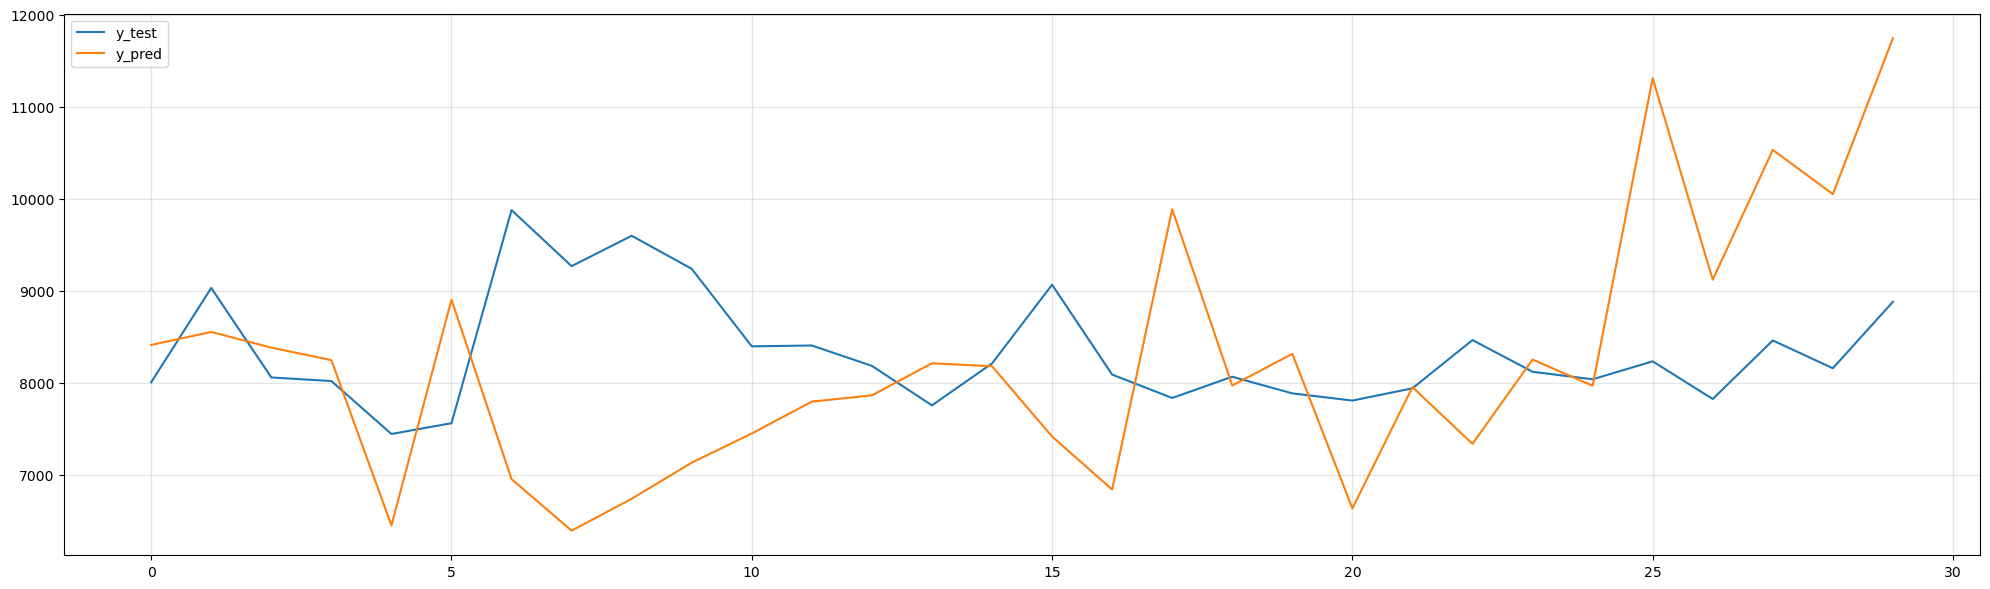

In [9]:
model = StackingRNN(128, 30, random_seed=42, loss_fn='mae', learning_rate=0.001, dropout=0.1,
                    device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))

y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# GAUNet

Using cpu backend
Epoch 1/3000  
55/55 - p0 - loss: 0.0683 - mae: 0.1623 - val_loss: 0.0390 - val_mae: 0.0390 - 0.28s/epoch - 0.005s/step
Epoch 2/3000  
55/55 - p0 - loss: 0.0549 - mae: 0.1094 - val_loss: 0.0340 - val_mae: 0.0340 - 0.25s/epoch - 0.005s/step
Epoch 3/3000  
55/55 - p0 - loss: 0.0467 - mae: 0.1010 - val_loss: 0.0334 - val_mae: 0.0334 - 0.25s/epoch - 0.005s/step
Epoch 4/3000  
55/55 - p1 - loss: 0.0438 - mae: 0.0970 - val_loss: 0.0348 - val_mae: 0.0348 - 0.25s/epoch - 0.005s/step
Epoch 5/3000  
55/55 - p2 - loss: 0.0428 - mae: 0.0950 - val_loss: 0.0368 - val_mae: 0.0368 - 0.25s/epoch - 0.005s/step
Epoch 6/3000  
55/55 - p3 - loss: 0.0435 - mae: 0.0946 - val_loss: 0.0388 - val_mae: 0.0388 - 0.25s/epoch - 0.005s/step
Epoch 7/3000  
55/55 - p4 - loss: 0.0458 - mae: 0.0950 - val_loss: 0.0405 - val_mae: 0.0405 - 0.25s/epoch - 0.005s/step
Epoch 8/3000  
55/55 - p5 - loss: 0.0471 - mae: 0.0957 - val_loss: 0.0419 - val_mae: 0.0419 - 0.27s/epoch - 0.005s/step
Epoch 9/3000  
55/55 -

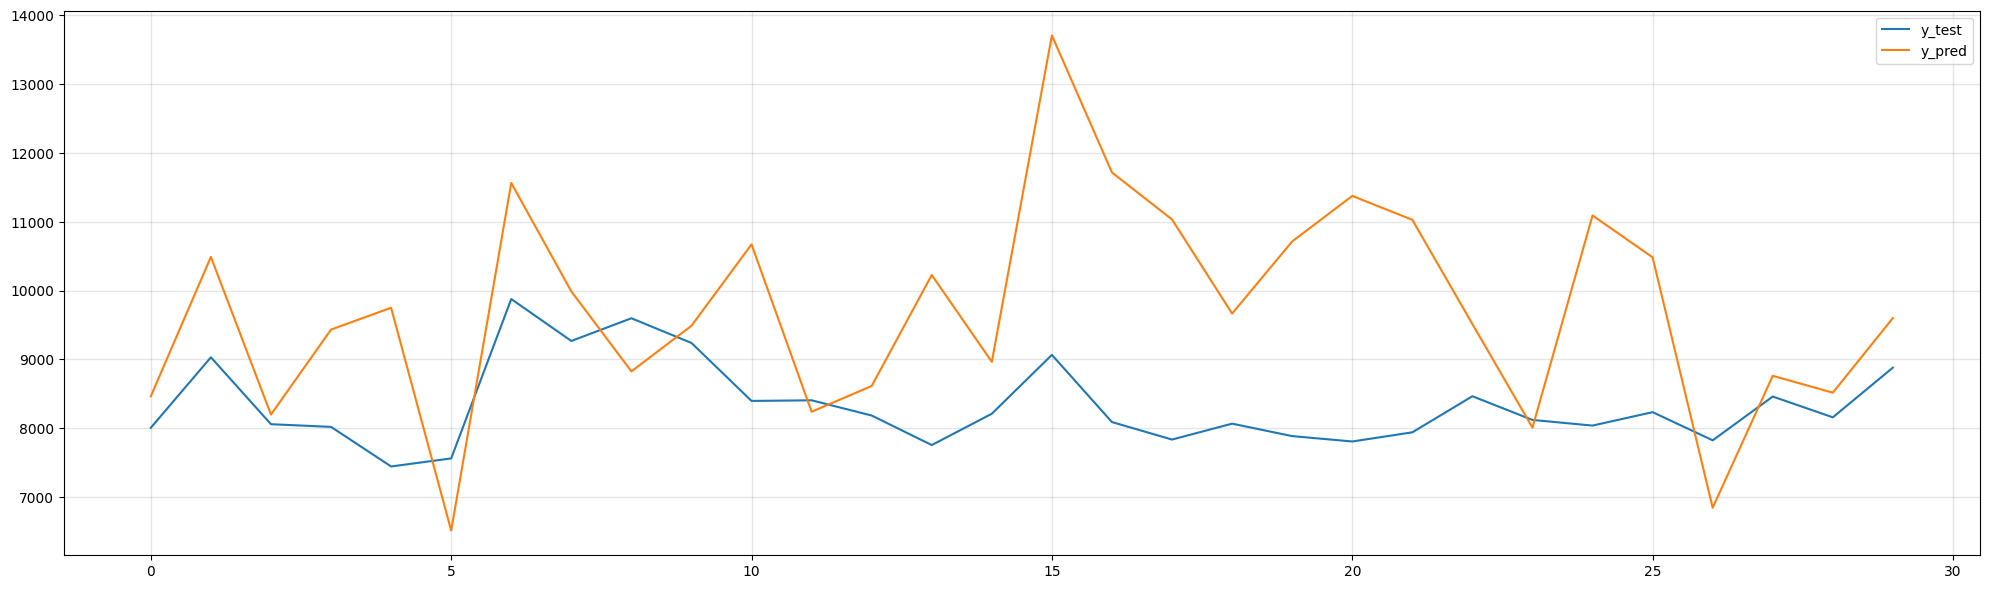

In [11]:
model = GAUNet(128, 30, random_seed=42, flip_features=False, learning_rate=0.001, level=2, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))
y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# Time2VecNet

Using cpu backend
Epoch 1/3000  
55/55 - p0 - loss: 0.1514 - mae: 0.2248 - val_loss: 0.1359 - val_mae: 0.1359 - 0.23s/epoch - 0.004s/step
Epoch 2/3000  
55/55 - p0 - loss: 0.1378 - mae: 0.1688 - val_loss: 0.1120 - val_mae: 0.1120 - 0.21s/epoch - 0.004s/step
Epoch 3/3000  
55/55 - p0 - loss: 0.0935 - mae: 0.1577 - val_loss: 0.0989 - val_mae: 0.0989 - 0.21s/epoch - 0.004s/step
Epoch 4/3000  
55/55 - p0 - loss: 0.0857 - mae: 0.1408 - val_loss: 0.0913 - val_mae: 0.0913 - 0.21s/epoch - 0.004s/step
Epoch 5/3000  
55/55 - p0 - loss: 0.0736 - mae: 0.1331 - val_loss: 0.0835 - val_mae: 0.0835 - 0.21s/epoch - 0.004s/step
Epoch 6/3000  
55/55 - p0 - loss: 0.0774 - mae: 0.1247 - val_loss: 0.0788 - val_mae: 0.0788 - 0.21s/epoch - 0.004s/step
Epoch 7/3000  
55/55 - p0 - loss: 0.0695 - mae: 0.1195 - val_loss: 0.0743 - val_mae: 0.0743 - 0.20s/epoch - 0.004s/step
Epoch 8/3000  
55/55 - p0 - loss: 0.0627 - mae: 0.1056 - val_loss: 0.0734 - val_mae: 0.0734 - 0.20s/epoch - 0.004s/step
Epoch 9/3000  
55/55 -

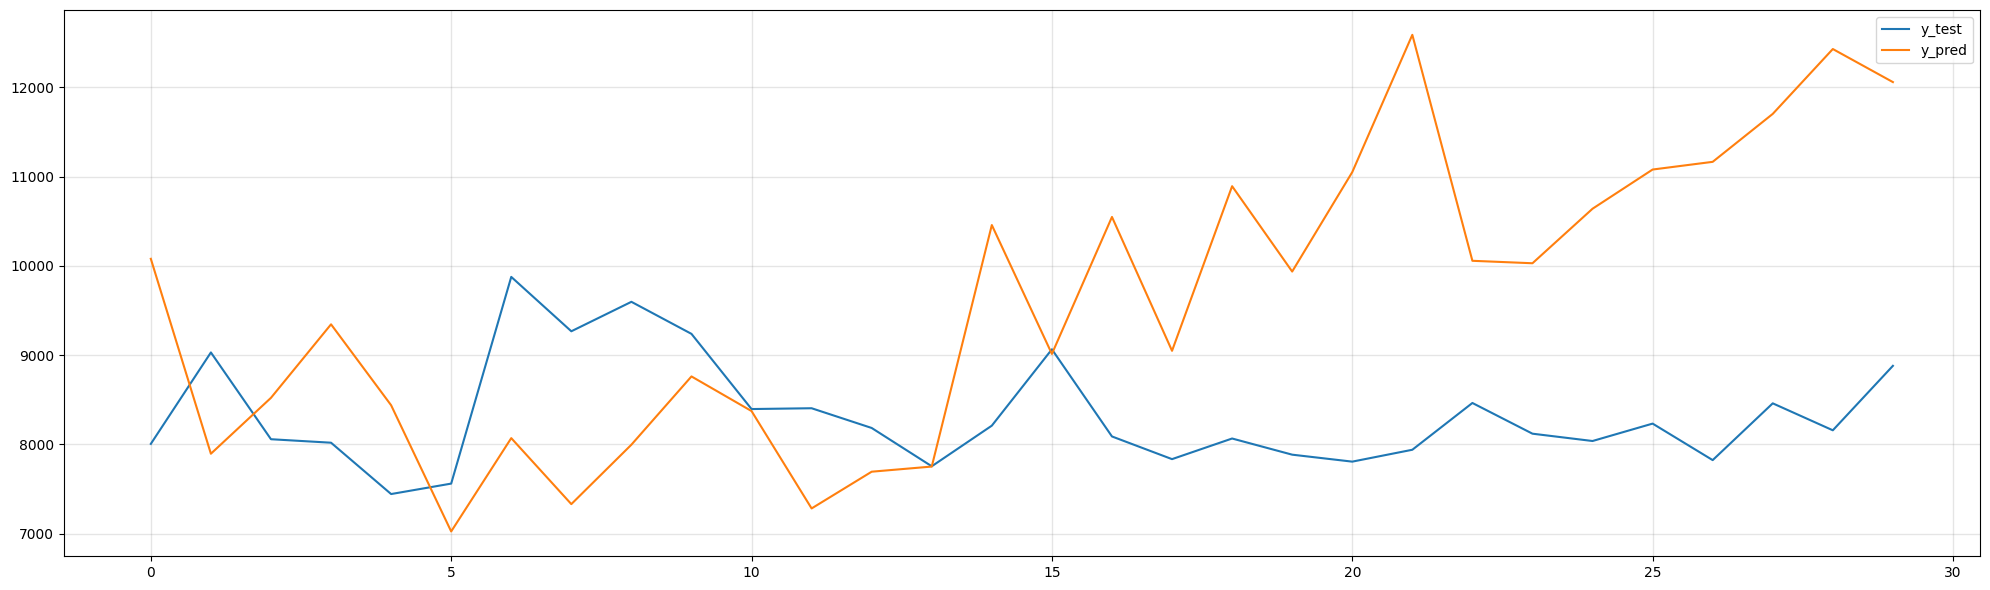

In [12]:
model = Time2VecNet(128, 30, random_seed=42, flip_features=False, learning_rate=0.001, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler='ReduceLROnPlateau')

y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))
y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))